# Importing Libraries

In [215]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

# Importing and Preprocessing Data

In [3]:
# Import data
df = pd.read_csv('data/noaa_midway_1997-05-01_2025-07-18.csv')
df = df[['DATE', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5']]
# Starting on April 1, 1998 because earlier data is almost entirely missing
df = df.iloc[331:]
# Replace missing data with 0
df = df.fillna(0)
df['DATE'] = pd.to_datetime(df['DATE'])
# Creating month column to be used as exogenous factor later
df['month'] = df['DATE'].dt.month
df = df.set_index('DATE')
df.head()

,AWND,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,month
DATE,,,,,,,,,
1998-04-01,13.42,0.20,49.0,39.0,260.0,200.0,25.9,33.1,4
1998-04-02,8.95,0.01,49.0,39.0,280.0,290.0,17.0,21.0,4
1998-04-03,14.54,0.00,44.0,39.0,30.0,20.0,25.1,32.0,4
1998-04-04,15.43,0.00,50.0,37.0,30.0,40.0,28.0,32.0,4
1998-04-05,6.71,0.00,52.0,31.0,20.0,30.0,15.0,17.0,4


<Axes: xlabel='DATE'>

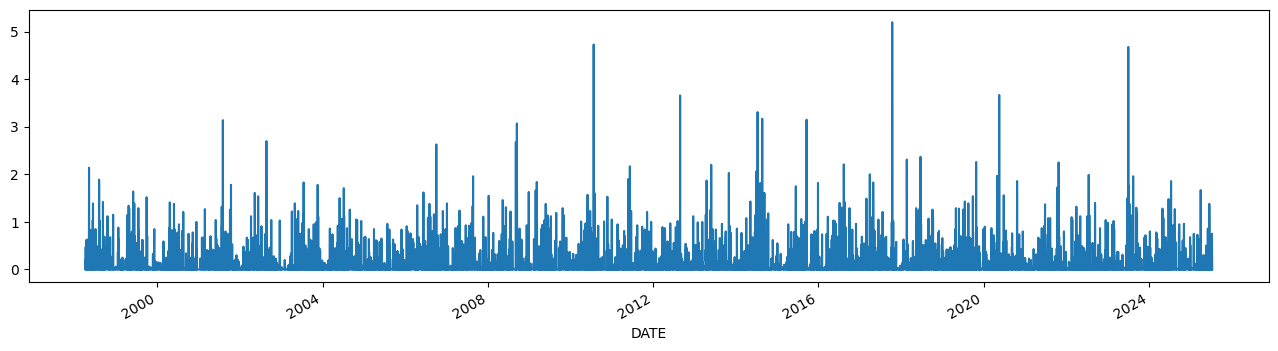

In [4]:
df['PRCP'].plot(figsize=(16,4))

In [5]:
# Creating threshold flag based on general rule that 0.42 in/day of rain is sufficient to offset artificial irrigation
# 1 means irrigation is required
df['irr'] = df['PRCP'] <= 0.42
df['irr'] = df['irr'].astype(int)

# Creating rolling monthly averages for PRCP, TMAX, and TMIN
df['PRCP_rolling'] = df['PRCP'].rolling(window=30, min_periods=1).mean()
df['TMAX_rolling'] = df['TMAX'].rolling(window=30, min_periods=1).mean()
df['TMIN_rolling'] = df['TMIN'].rolling(window=30, min_periods=1).mean()

df.head()

,AWND,PRCP,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,month,irr,PRCP_rolling,TMAX_rolling,TMIN_rolling
DATE,,,,,,,,,,,,,
1998-04-01,13.42,0.20,49.0,39.0,260.0,200.0,25.9,33.1,4,1,0.2000,49.000000,39.0
1998-04-02,8.95,0.01,49.0,39.0,280.0,290.0,17.0,21.0,4,1,0.1050,49.000000,39.0
1998-04-03,14.54,0.00,44.0,39.0,30.0,20.0,25.1,32.0,4,1,0.0700,47.333333,39.0
1998-04-04,15.43,0.00,50.0,37.0,30.0,40.0,28.0,32.0,4,1,0.0525,48.000000,38.5
1998-04-05,6.71,0.00,52.0,31.0,20.0,30.0,15.0,17.0,4,1,0.0420,48.800000,37.0


# Data Exploration

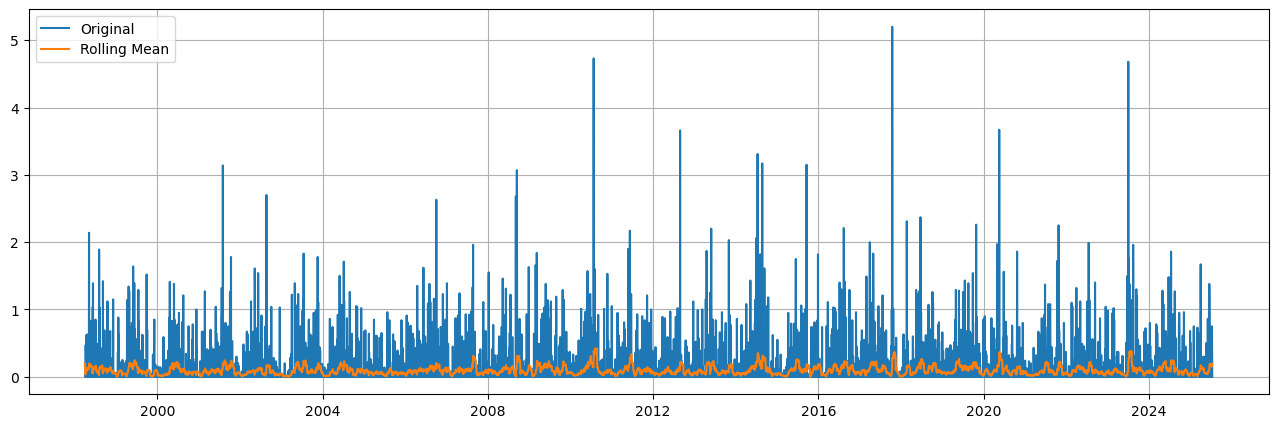

In [7]:
# Compare PRCP with its rolling average to check for stationarity
fig, ax = plt.subplots(figsize=(16,5), facecolor='w')
ax.plot(df['PRCP'], label='Original')
ax.plot(df['PRCP_rolling'], label='Rolling Mean')

ax.legend()
plt.grid()
plt.show();

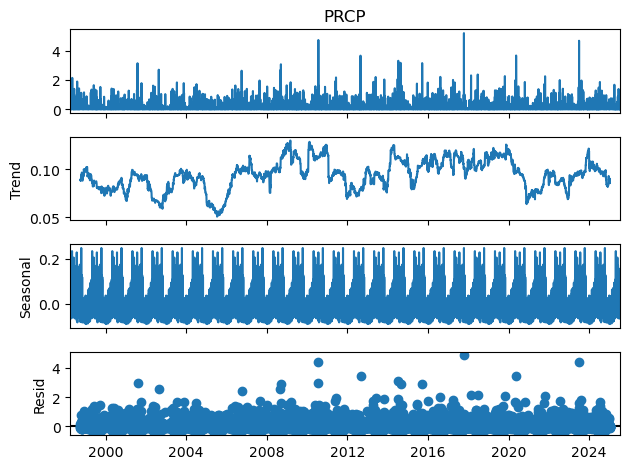

In [8]:
# Decomposing trend and seasonality
res = seasonal_decompose(df['PRCP'], period=365)
res.plot();

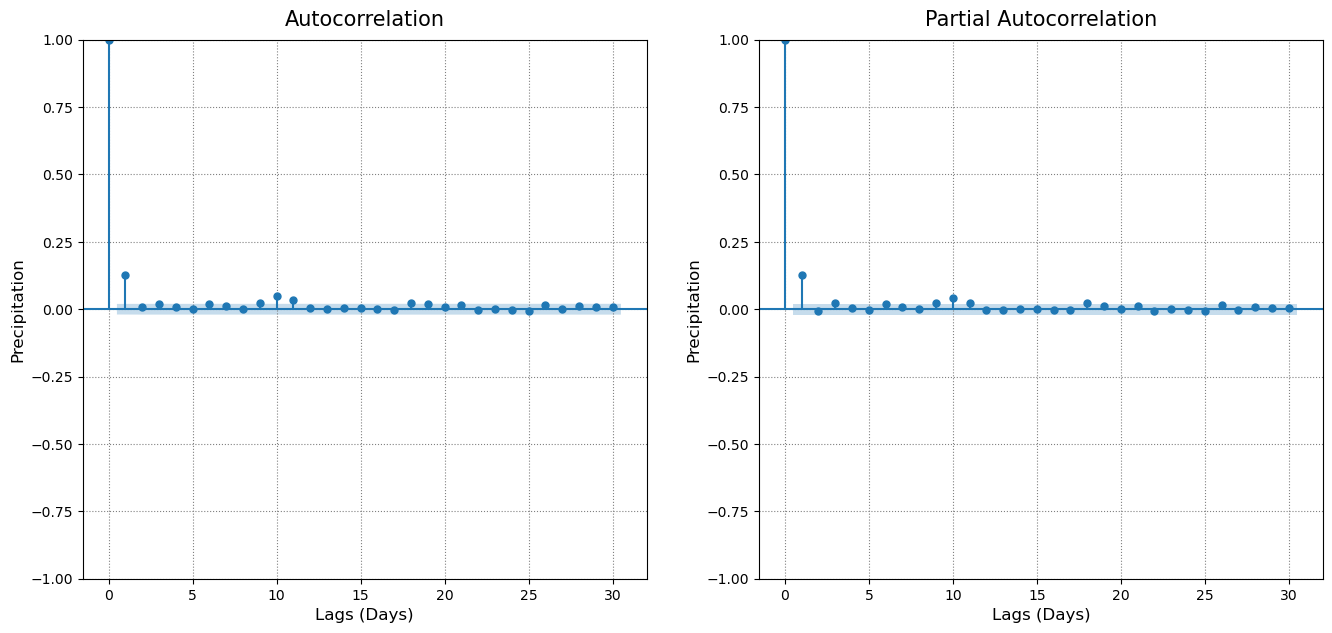

In [43]:
# Plotting autocorrelation and partial autocorrelation functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7), facecolor='w')
# ACF & PACF
plot_acf(df['PRCP'], ax=ax1, lags=30)
plot_pacf(df['PRCP'], ax=ax2, lags=30, method='ywm')

# Labels
ax1.set_title("Autocorrelation", fontsize=15, pad=10)
ax1.set_ylabel("Precipitation", fontsize=12)
ax1.set_xlabel("Lags (Days)", fontsize=12)

ax2.set_title("Partial Autocorrelation", fontsize=15, pad=10)
ax2.set_ylabel("Precipitation", fontsize=12)
ax2.set_xlabel("Lags (Days)", fontsize=12)
    
# Legend & Grid
ax1.grid(linestyle=":", color='grey')
ax2.grid(linestyle=":", color='grey')

plt.show()

# Time Series Analysis (SARIMAX)

In [18]:
# Separating dependent variable
X = df.drop('PRCP', axis=1)
y = df['PRCP']

# Splitting data into train and test sets. Test set is the final year's worth of data
X_test = X.iloc[-365:]
X_train = X.iloc[:-365]
y_test = y.iloc[-365:]
y_train = y.iloc[:-365]

In [20]:
# Splitting entire dataframe into train and test sets. Test set is the final year's worth of data
train_df = df.iloc[:-365]
test_df = df.iloc[-365:]

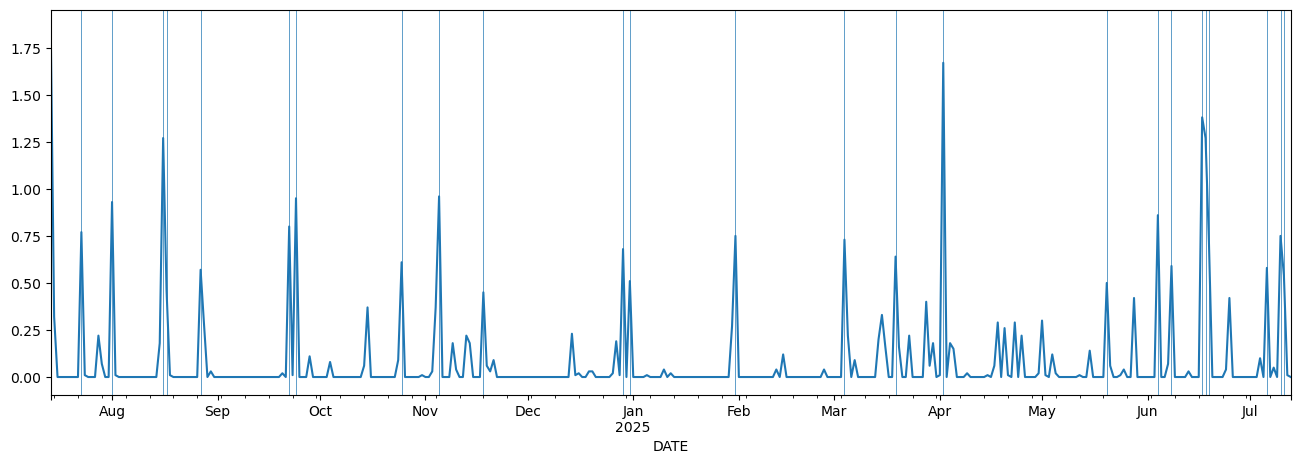

In [22]:
# Plotting test data with vertical lines to indicate days where precipitation was above the 0.42in/day threshold
fig, ax = plt.subplots(figsize=(16,5))
ax = test_df['PRCP'].plot();
for x in test_df[test_df['irr']==0].index:
    ax.axvline(x=x, linewidth=0.5)

In [24]:
# Searching for optimal ARIMA parameters with seasonality of 10 days
# 10 days was selected due to being the lag time with the strongest autocorrelation
auto_arima_start_time = time.time()
model = auto_arima(y=train_df['PRCP'], x=train_df[['TMAX_rolling', 'TMIN_rolling']], m=10)
auto_arima_end_time = time.time()
run_time = auto_arima_end_time - auto_arima_start_time
print(f"Auto Arima runtime: {run_time}")
model.summary()

Auto Arima runtime: 359.9204227924347


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 9599
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 10)   Log Likelihood               -1220.902
Date:                            Tue, 29 Jul 2025   AIC                           2451.804
Time:                                    00:48:08   BIC                           2487.651
Sample:                                         0   HQIC                          2463.963
                                           - 9599                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0292      0.009      3.353      0.001       0.012       0.046
ma.L1          0.1221      0.005     26.211      0.000       0.113       0.131
ar.S.L10       0.6929      0.088      7.882      0.000       0.521       0.865
ma.S.L10      -0.6585      0.091     -7.262      0.000      -0.836      -0.481
sigma2         0.0755      0.000    230.059      0.000       0.075       0.076
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1253705.43
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             5.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='DATE'>

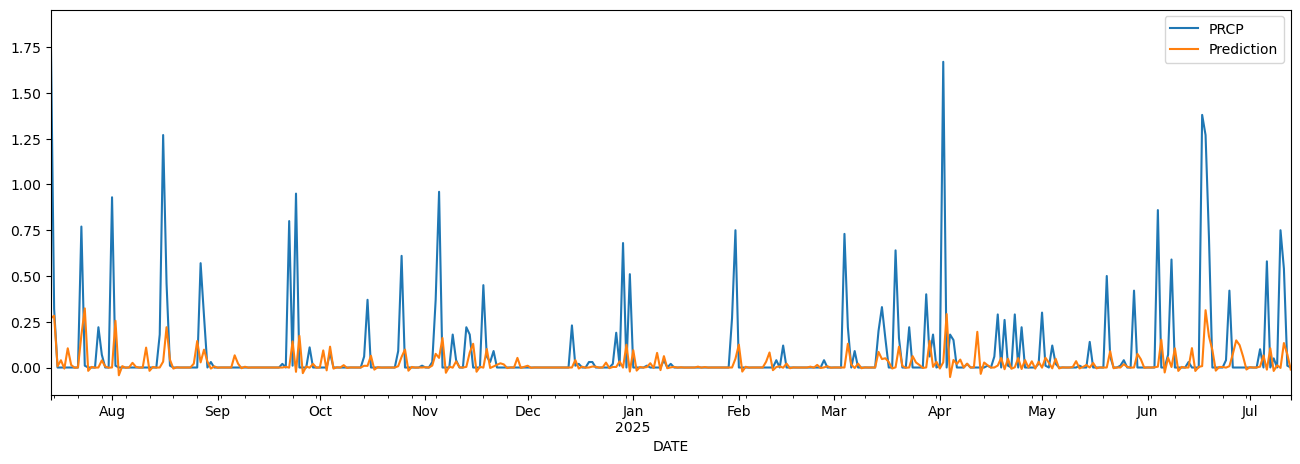

In [26]:
# Splitting off test set for last year's worth of data
train_df = df.iloc[:-365]
test_df = df.iloc[-365:]

# Creating SARIMAX model based on auto_arima results: SARIMAX(0, 0, 1)x(1, 0, 1, 10)
sarimax = SARIMAX(df['PRCP'], order=(0, 0, 1), seasonal_order=(1, 0, 0, 10))
sarimax_fit = sarimax.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = sarimax_fit.predict(start, end).rename('Prediction')

# Plotting predicted values against observed values
ax = test_df['PRCP'].plot(legend=True, figsize=(16,5))
prediction.plot(legend=True)

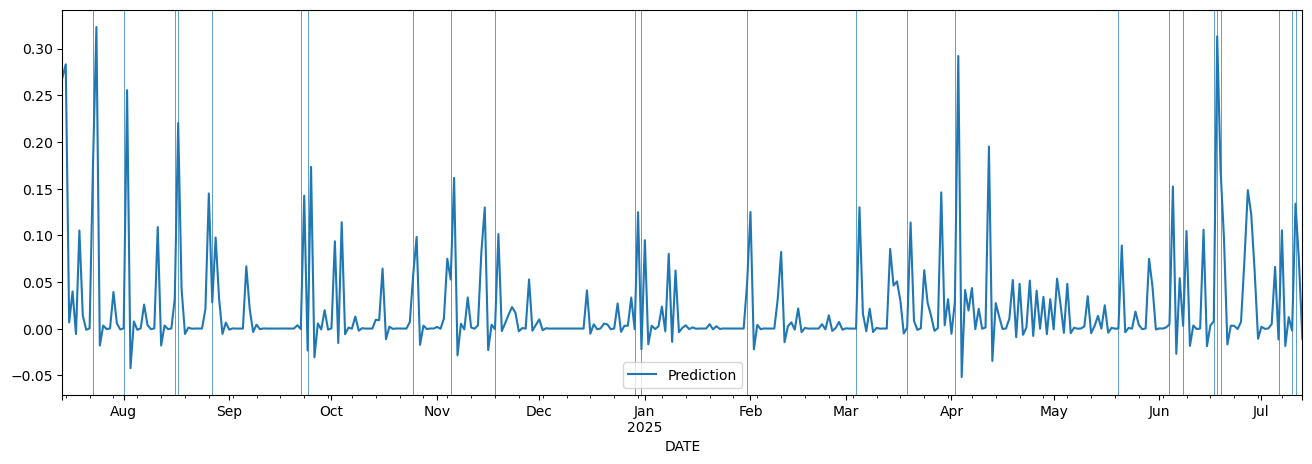

In [28]:
# Plotting predicted values with vertical lines indicating days where precipitation exceeded threshold
ax = prediction.plot(legend=True, figsize=(16,5))
for x in X_test[X_test['irr']==0].index:
    ax.axvline(x=x, linewidth=0.5)

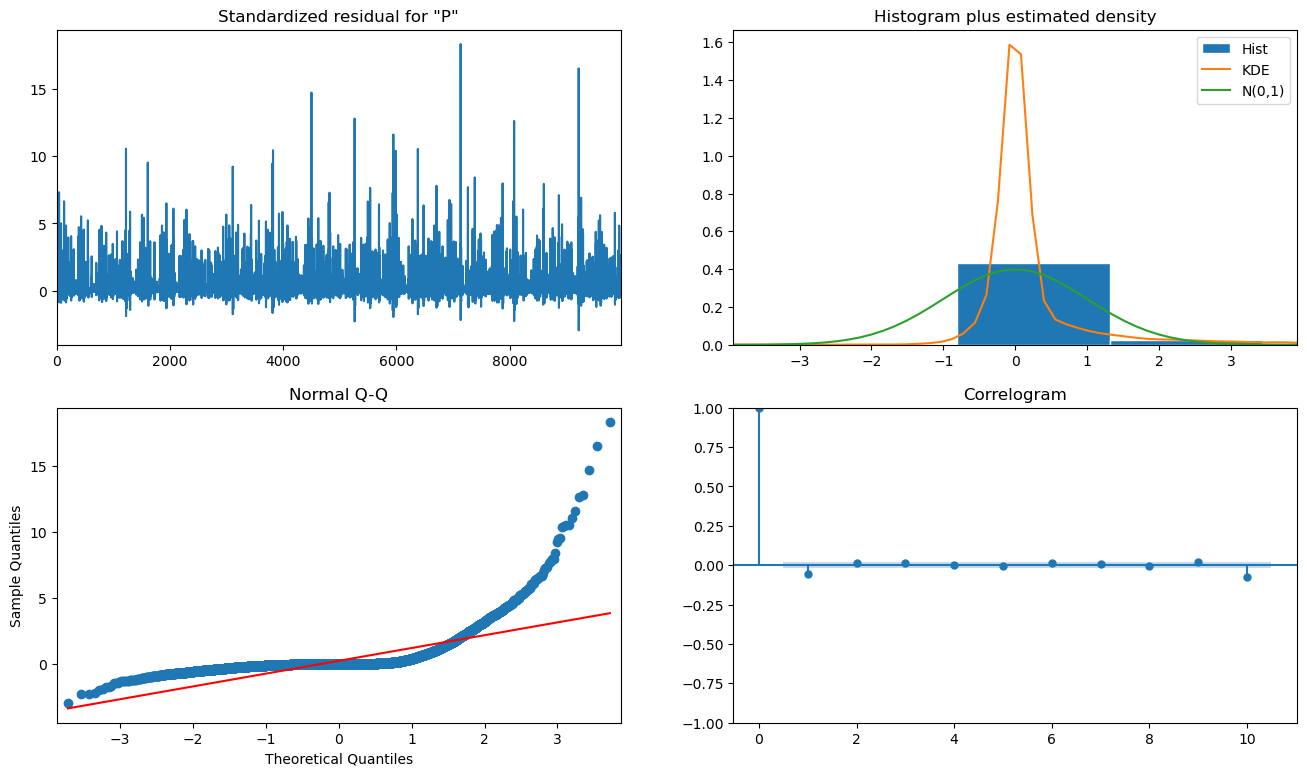

In [30]:
sarimax_fit.plot_diagnostics(figsize=(16,9));

## Findings
* Although the accuracy of the predicted precipitation amount is not very good, the model does a very good job at qualitatively identifying when a large rainfall event will occur. We can use this to inform us when natural rainfall will be sufficient to off-set artificial irrigation. Although the forecasted amount will be an underestimate, we can identify a threshold amount where we can be confident that the true precipitation will be significant
  * The predicted amount seems to have a lag of one day, which we can later shift to line up with observations
* The predicted value can sometimes be negative, which does not make sense for precipitation. Negative values can be interpreted as zero

* The standardised residual plot plots for the SARIMAX model show that there are no obvious patterns in the residuals
* The Normal Q-Q plot shows that there is a heavy tail to the distribution indicating the model may be heavily impacted by outliers
* The Histogram plus estimated density plot shows that the KDE follows a normal distribution, but with heavy tails as indicated by the normal Q-Q plot
* The correlogram indicates that there is still some correlation between lagged versions of itself, so there are still patterns that can be extracted

## Checking if exogenous features improve model

<Axes: xlabel='DATE'>

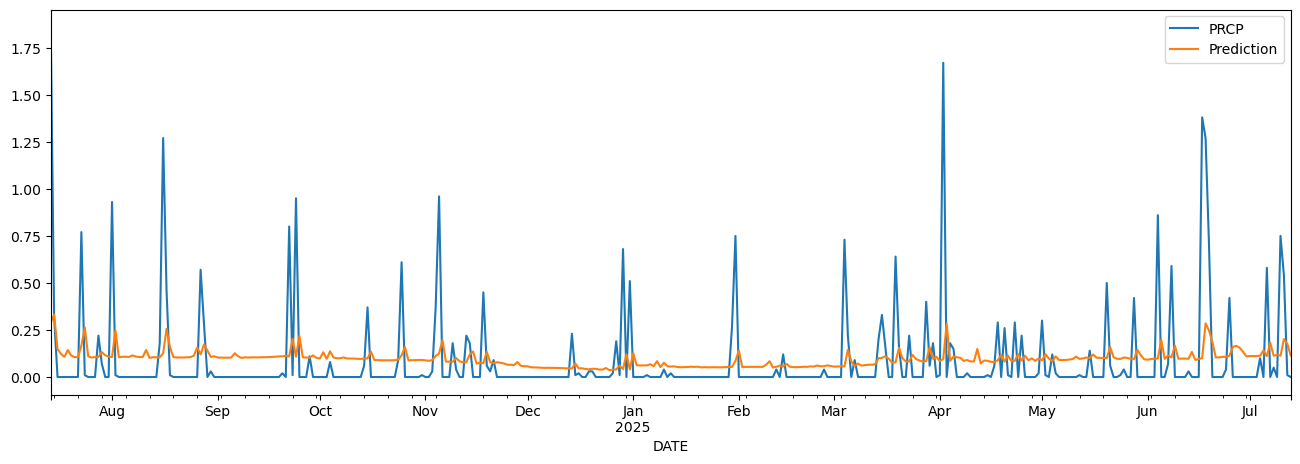

In [33]:
exog_feat = df[['month', 'TMAX_rolling', 'TMIN_rolling']]
sarimax = SARIMAX(df['PRCP'], exog=exog_feat, order=(1, 0, 0), seasonal_order=(1, 0, 0, 10))
res = sarimax.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = res.predict(start, end).rename('Prediction')

ax = test_df['PRCP'].plot(legend=True, figsize=(16,5))
prediction.plot(legend=True)

<Axes: xlabel='DATE'>

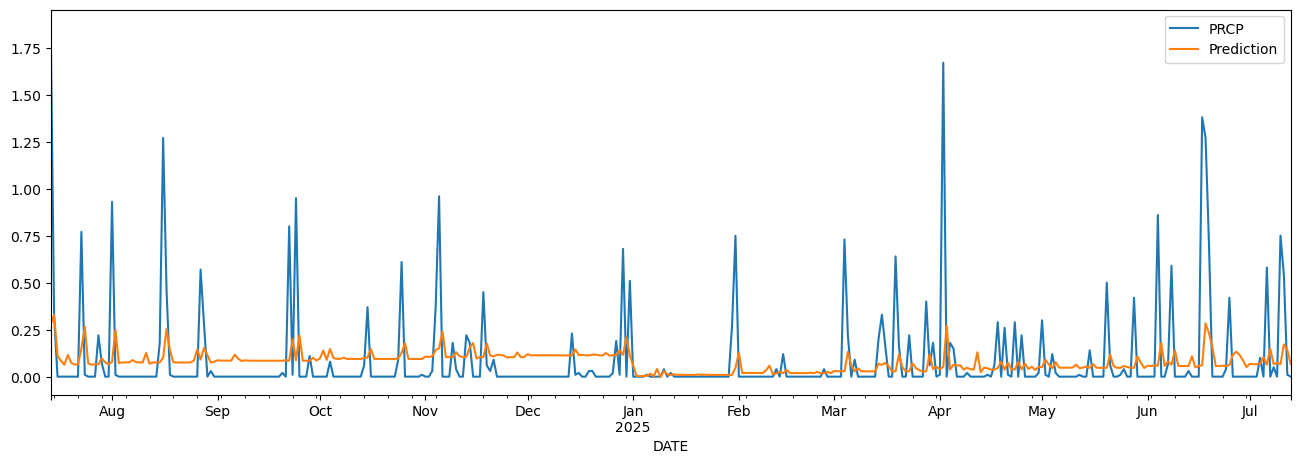

In [35]:
# Checking if only including month helps
exog_feat = df[['month']]
sarimax = SARIMAX(df['PRCP'], exog=exog_feat, order=(1, 0, 0), seasonal_order=(1, 0, 0, 10))
res = sarimax.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = res.predict(start, end).rename('Prediction')

ax = test_df['PRCP'].plot(legend=True, figsize=(16,5))
prediction.plot(legend=True)

## Findings
* Adding all three exogenous factors seems to add an offset bias to the model, as well as a very slightly curved annual trend
* Adding only the month exogenous adds a rising trend starting January 1st that resets on December 31st
* Adding exogenous factors such as a rolling average of TMAX and TMIN, as well as the month decreased model performance, indicating that these exogenous factors are not a primary factor in determining the precipitation amount or extracting patterns

# Proceeding with SARIMA model
* First, we'll create a summary table with the observed values and the predicted values, as well as the irrigation flag indicating when observed rainfall surpasses recommended irrigation amounts

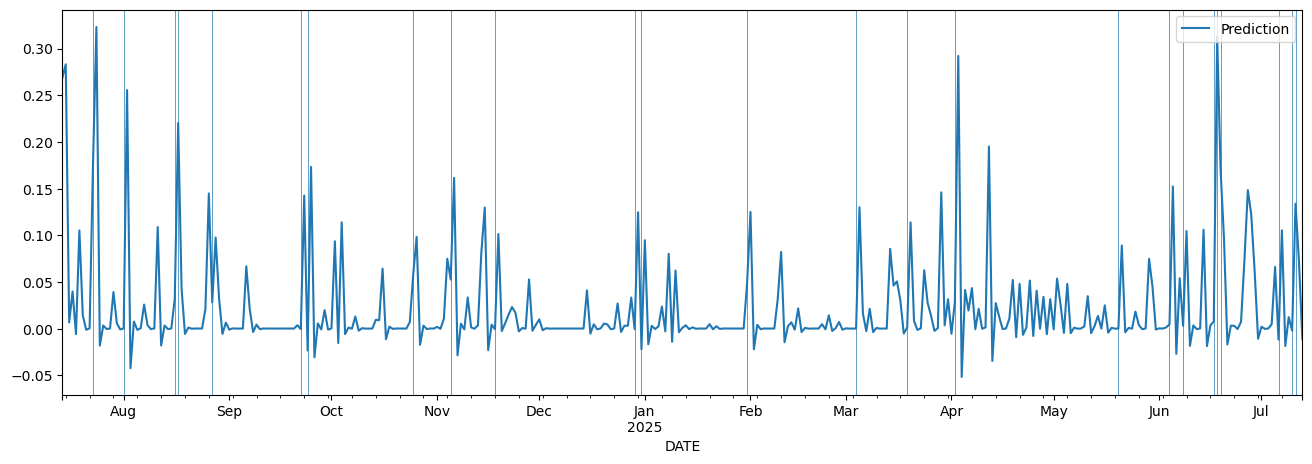

In [181]:
# Going back to SARIMA without exogenous factors: SARIMAX(0, 0, 1)x(1, 0, 0, 10)
sarimax = SARIMAX(df['PRCP'], order=(0, 0, 1), seasonal_order=(1, 0, 0, 10))
sarimax_fit = sarimax.fit()
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = sarimax_fit.predict(start, end).rename('Prediction')

ax = prediction.plot(legend=True, figsize=(16,5))
ax.legend(loc='upper right')
for x in X_test[X_test['irr']==0].index:
    ax.axvline(x=x, linewidth=0.5)

In [182]:
summary = pd.DataFrame({"Observed": test_df['PRCP'], "Prediction": prediction, "Irrigation?": test_df['irr']})
summary

,Observed,Prediction,Irrigation?
DATE,,,
2024-07-14,1.86,0.268553,0
2024-07-15,0.32,0.283066,1
2024-07-16,0.00,0.006569,1
2024-07-17,0.00,0.039750,1
2024-07-18,0.00,-0.005901,1
...,...,...,...
2025-07-09,0.00,0.012223,1
2025-07-10,0.75,-0.002174,0
2025-07-11,0.54,0.133787,0


In [187]:
# Shifting the predictions backwards one day and removing last entry since the prediction won't exist
summary_shift = pd.DataFrame({"Observed": test_df['PRCP'], "Prediction": prediction.shift(periods=-1, axis=0), "Irrigation?": test_df['irr']})
summary_shift = summary_shift.drop(summary_shift.index[-1])
summary_shift

,Observed,Prediction,Irrigation?
DATE,,,
2024-07-14,1.86,0.283066,0
2024-07-15,0.32,0.006569,1
2024-07-16,0.00,0.039750,1
2024-07-17,0.00,-0.005901,1
2024-07-18,0.00,0.105099,1
...,...,...,...
2025-07-08,0.05,0.012223,1
2025-07-09,0.00,-0.002174,1
2025-07-10,0.75,0.133787,0


In [221]:
models = []
mses = []
rmses = []

# Compute MSE for SARIMA model
sarima_mse = mean_squared_error(summary['Observed'], summary['Prediction'])
sarima_rmse = root_mean_squared_error(summary['Observed'], summary['Prediction'])
models.append('SARIMA')
mses.append(sarima_mse)
rmses.append(sarima_rmse)

# Computing MSE for shifted predictions
shifted_sarima_mse = mean_squared_error(summary_shift['Observed'], summary_shift['Prediction'])
shifted_sarima_rmse = root_mean_squared_error(summary_shift['Observed'], summary_shift['Prediction'])
models.append('Shifted SARIMA')
mses.append(shifted_sarima_mse)
rmses.append(shifted_sarima_rmse)

errors = pd.DataFrame({"Model": models, "MSE": mses, "RMSE": rmses})
errors

,Model,MSE,RMSE
0,SARIMA,0.058789,0.242464
1,Shifted SARIMA,0.044762,0.211571


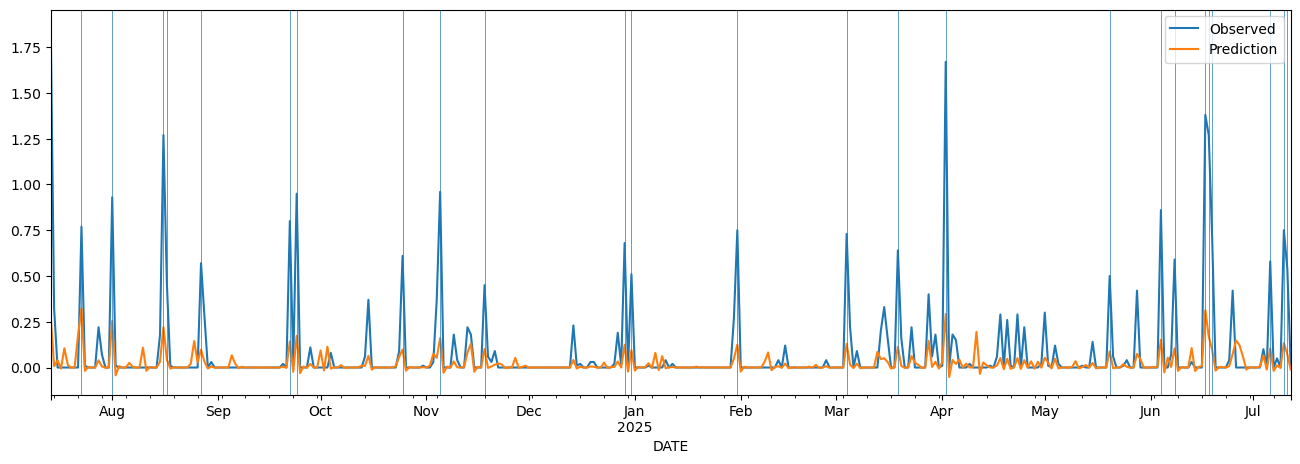

In [193]:
# Plotting shifted predictions against observations and significant rain storms as vertical bars
ax = summary_shift.plot(y=['Observed', 'Prediction'], legend=True, figsize=(16,5))
ax.legend(loc='upper right')
for x in X_test[X_test['irr']==0].index:
    ax.axvline(x=x, linewidth=0.5)

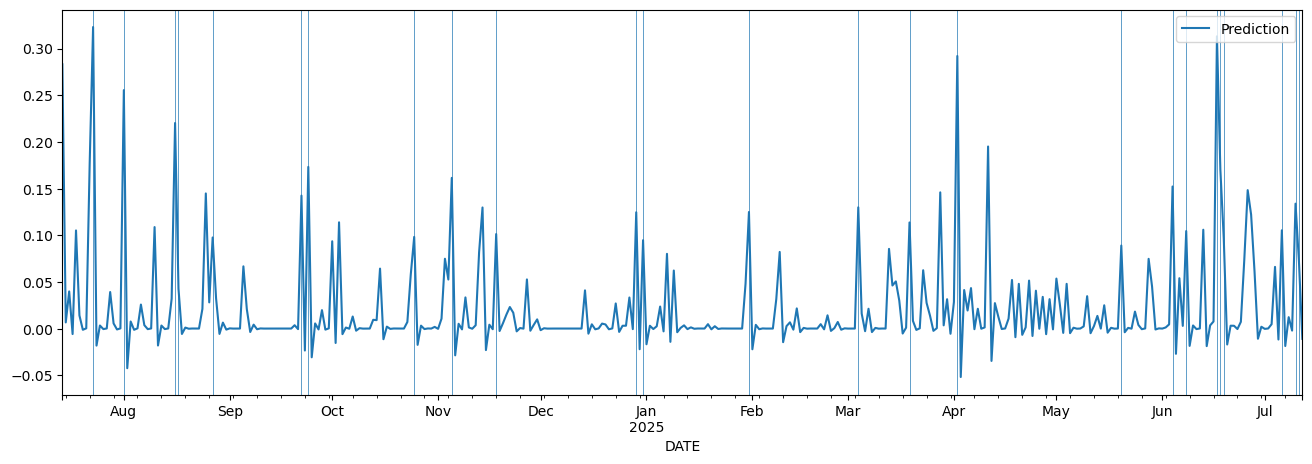

In [195]:
# Predictions plotted with significant rainstorms
ax = summary_shift.plot(y=['Prediction'], legend=True, figsize=(16,5))
ax.legend(loc='upper right')
for x in X_test[X_test['irr']==0].index:
    ax.axvline(x=x, linewidth=0.5)

In [223]:
past_threshold = summary_shift[summary_shift['Prediction'] >= 0.15]
past_threshold['Irrigation?'].value_counts()[0]

10

In [225]:
past_threshold['Irrigation?'].value_counts()[1]

2

In [235]:
summary_shift[summary_shift['Irrigation?'] == 0]

,Observed,Prediction,Irrigation?
DATE,,,
2024-07-14,1.86,0.283066,0
2024-07-23,0.77,0.323017,0
2024-08-01,0.93,0.255405,0
2024-08-16,1.27,0.220200,0
2024-08-17,0.46,0.042653,0
2024-08-27,0.57,0.097567,0
2024-09-22,0.80,0.142406,0
2024-09-24,0.95,0.173162,0
2024-10-25,0.61,0.098180,0
